# Multi-omics data integration
We will perform a short integration of a proteomics and lipidomics dataset obtained for a demylination (i.e., damage to the myelin sheath surrounding neurons) experiment with four time points given by days (0, 4, 7, and 14, abbreviated by 'd00', 'd04', 'd07', and 'd14'). See details of this study in [Penkert21].

We can download both datasets which are provided by xOmics as use-case datasets as follows:

In [26]:
import xomics as xo
df_prot = xo.load_dataset(name="PROT_DEMYLINATION")
df_lip = xo.load_dataset(name="LIPID_DEMYLINATION")

Focusing on a comparison of day 7 against day 0, we can first define all constants for our analysis:

In [27]:
groups = ["d00", "d03", "d07", "d14"]
args_col = dict(col_fc="log2_fc_(d07/d00)", col_pval="-log10_p-value_(d07/d00)")
# Lipidomics data were measured in pikomol using an external standard
args_lip = dict(col_id="lipid_id", col_name="lipid_name", str_quant="pmol")
# Proteomics data were measured using label free quantification (LFQ)
args_prot = dict(col_id="protein_id", col_name="gene_name", str_quant="log2_lfq")

We first perform some filtering steps and compute the fold changes for our proteomics data:

In [28]:
# Pre-processing
pp = xo.PreProcess(**args_prot)
pr = xo.pRank(**args_prot)
df_lfq = pp.filter_groups(df=df_prot, groups=groups)
df_lfq = pp.filter_duplicated_names(df=df_lfq, col="gene_name")
# Compute fold change (FC) and p-values
df_fc = pp.run(df=df_lfq, groups=groups, groups_ctrl=["d00"])
df_fc = pp.filter_nan(df=df_fc, cols=["log2_fc_(d07/d00)", "-log10_p-value_(d07/d00)"])


Now the threshold based significance and P-scores can be computed:

In [29]:
df_fc = pp.add_significance(df=df_fc, **args_col)
df_fc = pr.p_score(df_fc=df_fc, **args_col)
df_fc.head(5)

,protein_id,gene_name,log2_fc_(d03/d00),log2_fc_(d07/d00),log2_fc_(d14/d00),-log10_p-value_(d03/d00),-log10_p-value_(d07/d00),-log10_p-value_(d14/d00),sig_class,p_score
0,Q8K4G5,Ablim1,-0.528,-0.6825,-0.220,4.230306,5.312642,3.140084,Down,0.340022
1,Q91ZJ5,Ugp2,-0.036,-0.2850,-0.518,0.248030,4.640008,6.791086,Unchanged,0.246418
2,P53986,Slc16a1,-0.084,-0.4410,-0.806,0.317540,3.634130,6.823463,Unchanged,0.228351
3,P24270,Cat,-0.186,-0.7560,-0.384,1.586811,5.169079,4.096977,Down,0.345767
4,Q99KC8,Vwa5a,-0.352,-0.7130,-1.056,1.420013,4.742200,7.742758,Down,0.320359


We use this to highlight the proteins with the strongest proteomic signal in a volcano plot

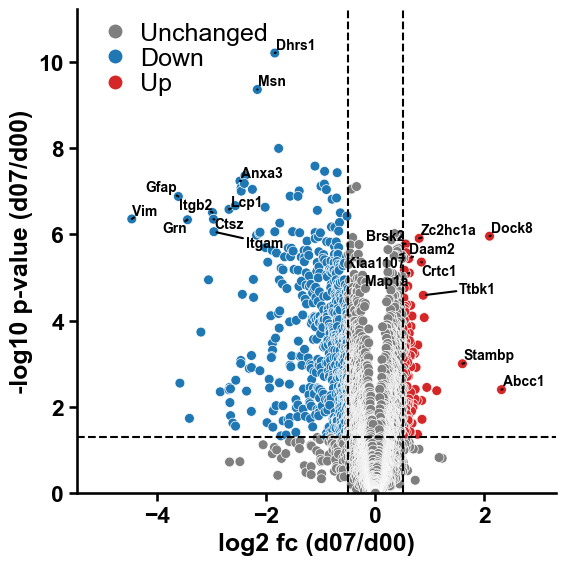

In [30]:
import matplotlib.pyplot as plt
df_fc = df_fc.sort_values(by="p_score", ascending=False)
top_genes_up = df_fc[df_fc["sig_class"] == "Up"]["gene_name"].to_list()[0:10]
top_genes_down = df_fc[df_fc["sig_class"] == "Down"]["gene_name"].to_list()[0:10]
top_genes = top_genes_down + top_genes_up
xo.plot_settings()
xo.plot_volcano(df=df_fc, **args_col, names_to_annotate=top_genes, col_names="gene_name")
plt.tight_layout()
plt.show()

We can now obtain the significantly altered proteins and perform a gene set enrichment analysis using `g:Profiler <https://biit.cs.ut.ee/gprofiler/gost>`_ with default settings and using all Gene Ontology and biological pathways data sources. A list of 'target_genes' has to be provided, and it is highly recommended to use a customized 'background' by setting in 'Advanced options' the 'Statistical domain scope' to 'Custom' and copy-pasting your entire list of detected proteins.

In [31]:
background = df_fc["gene_name"].to_list()
target_genes = df_fc[df_fc["sig_class"].isin(["Up", "Down"])]["gene_name"].to_list()
print(f"Target list comprises {len(target_genes)} genes, which is a subset of the complete background list including {len(background)} genes.")

Target list comprises 644 genes, which is a subset of the complete background list including 4526 genes.


Run g:Profiler und download the 'Detailed Results' as GEM and convert the .txt file into a .tsv file. We provide the results of this enrichment analysis as use-case by using `xo.load_dataset` and setting `name='gProfiler_DEMYLINATION'`:

In [32]:
df_gprof = xo.load_dataset(name="gProfiler_DEMYLINATION")
df_gporf = pp.apply_log(df=df_gprof, cols=["p.val"], log2=False, neg=True)
df_gprof.head(5)

,go.id,description,p.val,fdr,phenotype,genes
0,GO:0003735,structural constituent of ribosome,2.875376e-09,2.875376e-09,1,"RPL18,RPL27,RPL5,RPL27A,RPS28,RPL29,RPS14,MRPL..."
1,GO:0003779,actin binding,2.727871e-04,2.727871e-04,1,"DAAM2,ANLN,MRTFB,ADCY8,PHACTR1,MAP1A,ABLIM1,CO..."
2,GO:0005198,structural molecule activity,4.333399e-02,4.333399e-02,1,"CRYAB,PLLP,MAP1A,RPL18,RPL27,H4C1,CD2AP,RPL5,R..."
3,GO:0002181,cytoplasmic translation,9.007092e-05,9.007092e-05,1,"RPL18,RPL27,HNRNPU,RPL5,YBX1,RPL27A,RPS28,NMNA..."
4,GO:0042274,ribosomal small subunit biogenesis,6.388875e-04,6.388875e-04,1,"RPS28,RPS14,RPS8,RPS13,RPS24,RPS3A,RPS5,RPS12,..."


These enrichment results can be used to obtain a protein-centric enrichment-based ranking score called E-score:

In [33]:
# TODO

To perform an enrichment analysis for the lipidomics data, we obtain as well all significantly changed lipids and use this time `LION/web server <http://www.lipidontology.com/>`. The results are provided by xOmics by using `xo.load_dataset` with `name='LION_DEMYLINATION'`: